In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

/home/dada/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")

import string
characters = string.digits + string.ascii_uppercase + string.whitespace[0]
print(characters)

width, height, n_len, n_class = 200, 60, 6, len(characters)+1

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ 


# Model

In [3]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Conv2D(filters=32*(2**i), kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=32*(2**i), kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input=input_tensor, output=x)

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

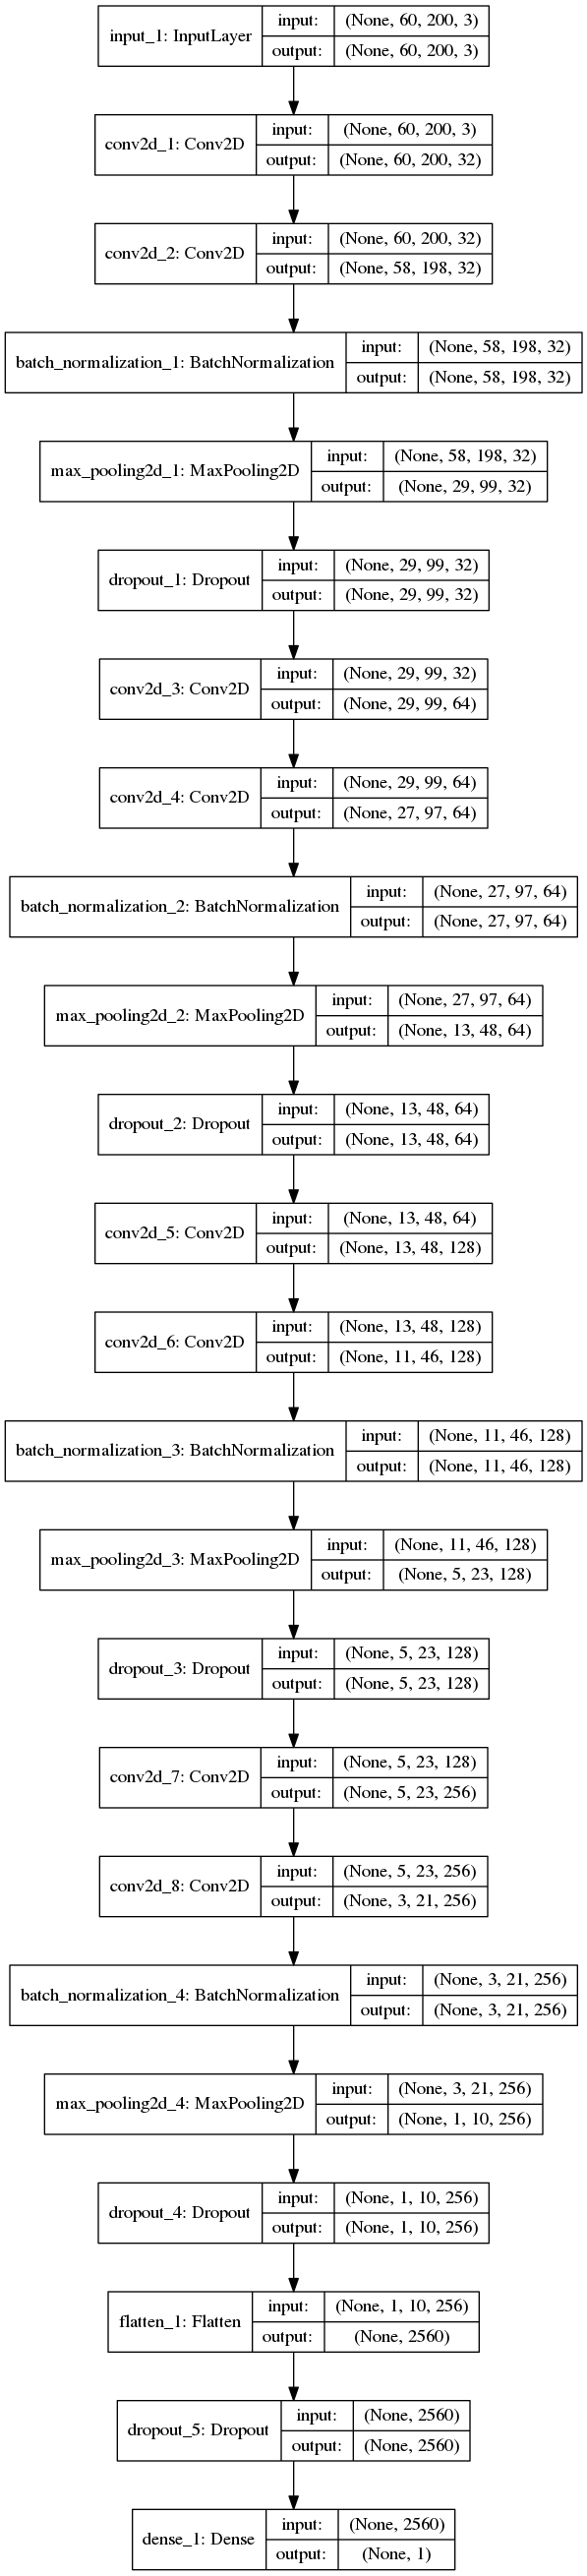

In [4]:
from IPython.display import Image
from keras.utils import plot_model

plot_model(model, to_file='models/model_split.png', show_shapes=True)
Image('models/model_split.png')

# Read data

In [5]:
import pandas as pd
labels = pd.read_csv('data/captcha/label.csv', header=None)
labels.head(10)

all_imgs = [plt.imread('data/captcha/'+str(i+1)+'.jpg') for i in range(131072)]

# Data generator

In [6]:
from keras.utils import to_categorical
def gen(batch_size=128):
    while True:
        batch_idx = np.random.randint(100000, size=batch_size)
        X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
        y = np.zeros((batch_size, 1), dtype=np.uint8)
        for i, idx in enumerate(batch_idx):
            img = all_imgs[idx]
            label = labels[1][idx]
            
            X[i] = img
            y[i] = 1 if len(label)==6 else 0
                
        yield X, y

In [7]:
def gen_val(batch_size=128):
    while True:
        batch_idx = np.random.randint(31072, size=batch_size)
        X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
        y = np.zeros((batch_size, 1), dtype=np.uint8)
        for i, idx in enumerate(batch_idx):
            idx += 100000
            img = all_imgs[idx]
            label = labels[1][idx]
            X[i] = img
            y[i] = 1 if len(label)==6 else 0
            
        yield X, y

# Decoder

Text(0.5,1,'6')

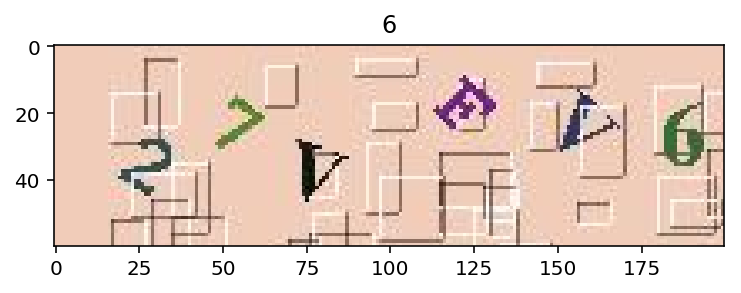

In [8]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(6 if y==1 else 5)

# Training

In [9]:
from keras.callbacks import *
mcp = ModelCheckpoint('models/model_cnn_5.h5', 
                          monitor="val_acc", 
                          save_best_only=True, 
                          save_weights_only=False)

In [13]:
K.tensorflow_backend._get_available_gpus()
history = model.fit_generator(gen(128), steps_per_epoch=int(51200/512), nb_epoch=20,
                    callbacks=[EarlyStopping(patience=1), mcp],
                    validation_data=gen_val(128), validation_steps=30)

Epoch 1/20
100/100 [==============================] - 16s 158ms/step - loss: 0.0071 - acc: 0.9980 - val_loss: 0.2268 - val_acc: 0.9492
Epoch 2/20
100/100 [==============================] - 16s 158ms/step - loss: 0.0058 - acc: 0.9977 - val_loss: 0.0090 - val_acc: 0.9977
Epoch 3/20
100/100 [==============================] - 16s 159ms/step - loss: 0.0089 - acc: 0.9978 - val_loss: 0.0186 - val_acc: 0.9945


# Testing

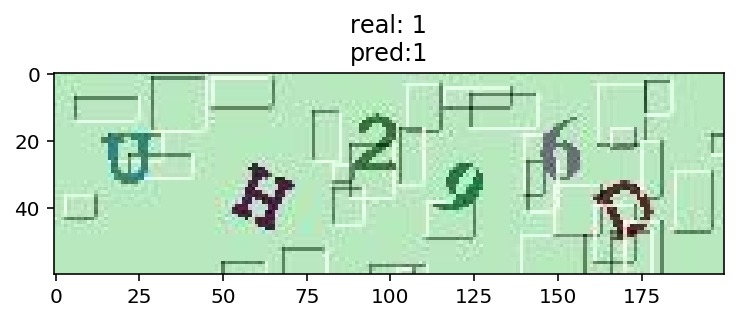

In [19]:
X, y = next(gen(1))
y_pred = model.predict(X)
y_pred = 0 if y_pred[0][0] < 0.5 else 1
plt.title('real: %s\npred:%s'%(y[0][0], y_pred))
plt.imshow(X[0])
plt.show()

In [20]:
#model.save('models/model_cnn_split.h5')